In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

2024-05-09 20:29:59.635525: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25363087360


# Sign Prediction Tests
> Comparisons between Diffusion Curvature and the Competition

Here we employ saddles and spheres of increasing dimension to test our model's ability to detect sign.

# Machinery

In [2]:
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

In [3]:
SS1 = SadSpheres(
    dimension = dims, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)']


In [4]:
SS1.imported_methods

['ground truth',
 'Diffusion Curvature (Entropic)',
 'Diffusion Curvature (Wasserstein)']

In [9]:
SS1.save_results()

In [5]:
# graph_former = partial(get_curvature_agnostic_graph, k = dim*2, )
graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)
for X in tqdm(SS1):
    if "Diffusion Curvature (Entropic)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Ollivier",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Entropic)")
    if "Diffusion Curvature (Wasserstein)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Wasserstein)")


  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
SS1.table()

ks
                                   pearson_r  sign_score
ground truth                        1.000000       1.000
Diffusion Curvature (Entropic)      0.736951       1.000
Diffusion Curvature (Wasserstein)  -0.516870       0.395


{'ks':                                    pearson_r  sign_score
 ground truth                        1.000000       1.000
 Diffusion Curvature (Entropic)      0.736951       1.000
 Diffusion Curvature (Wasserstein)  -0.516870       0.395}

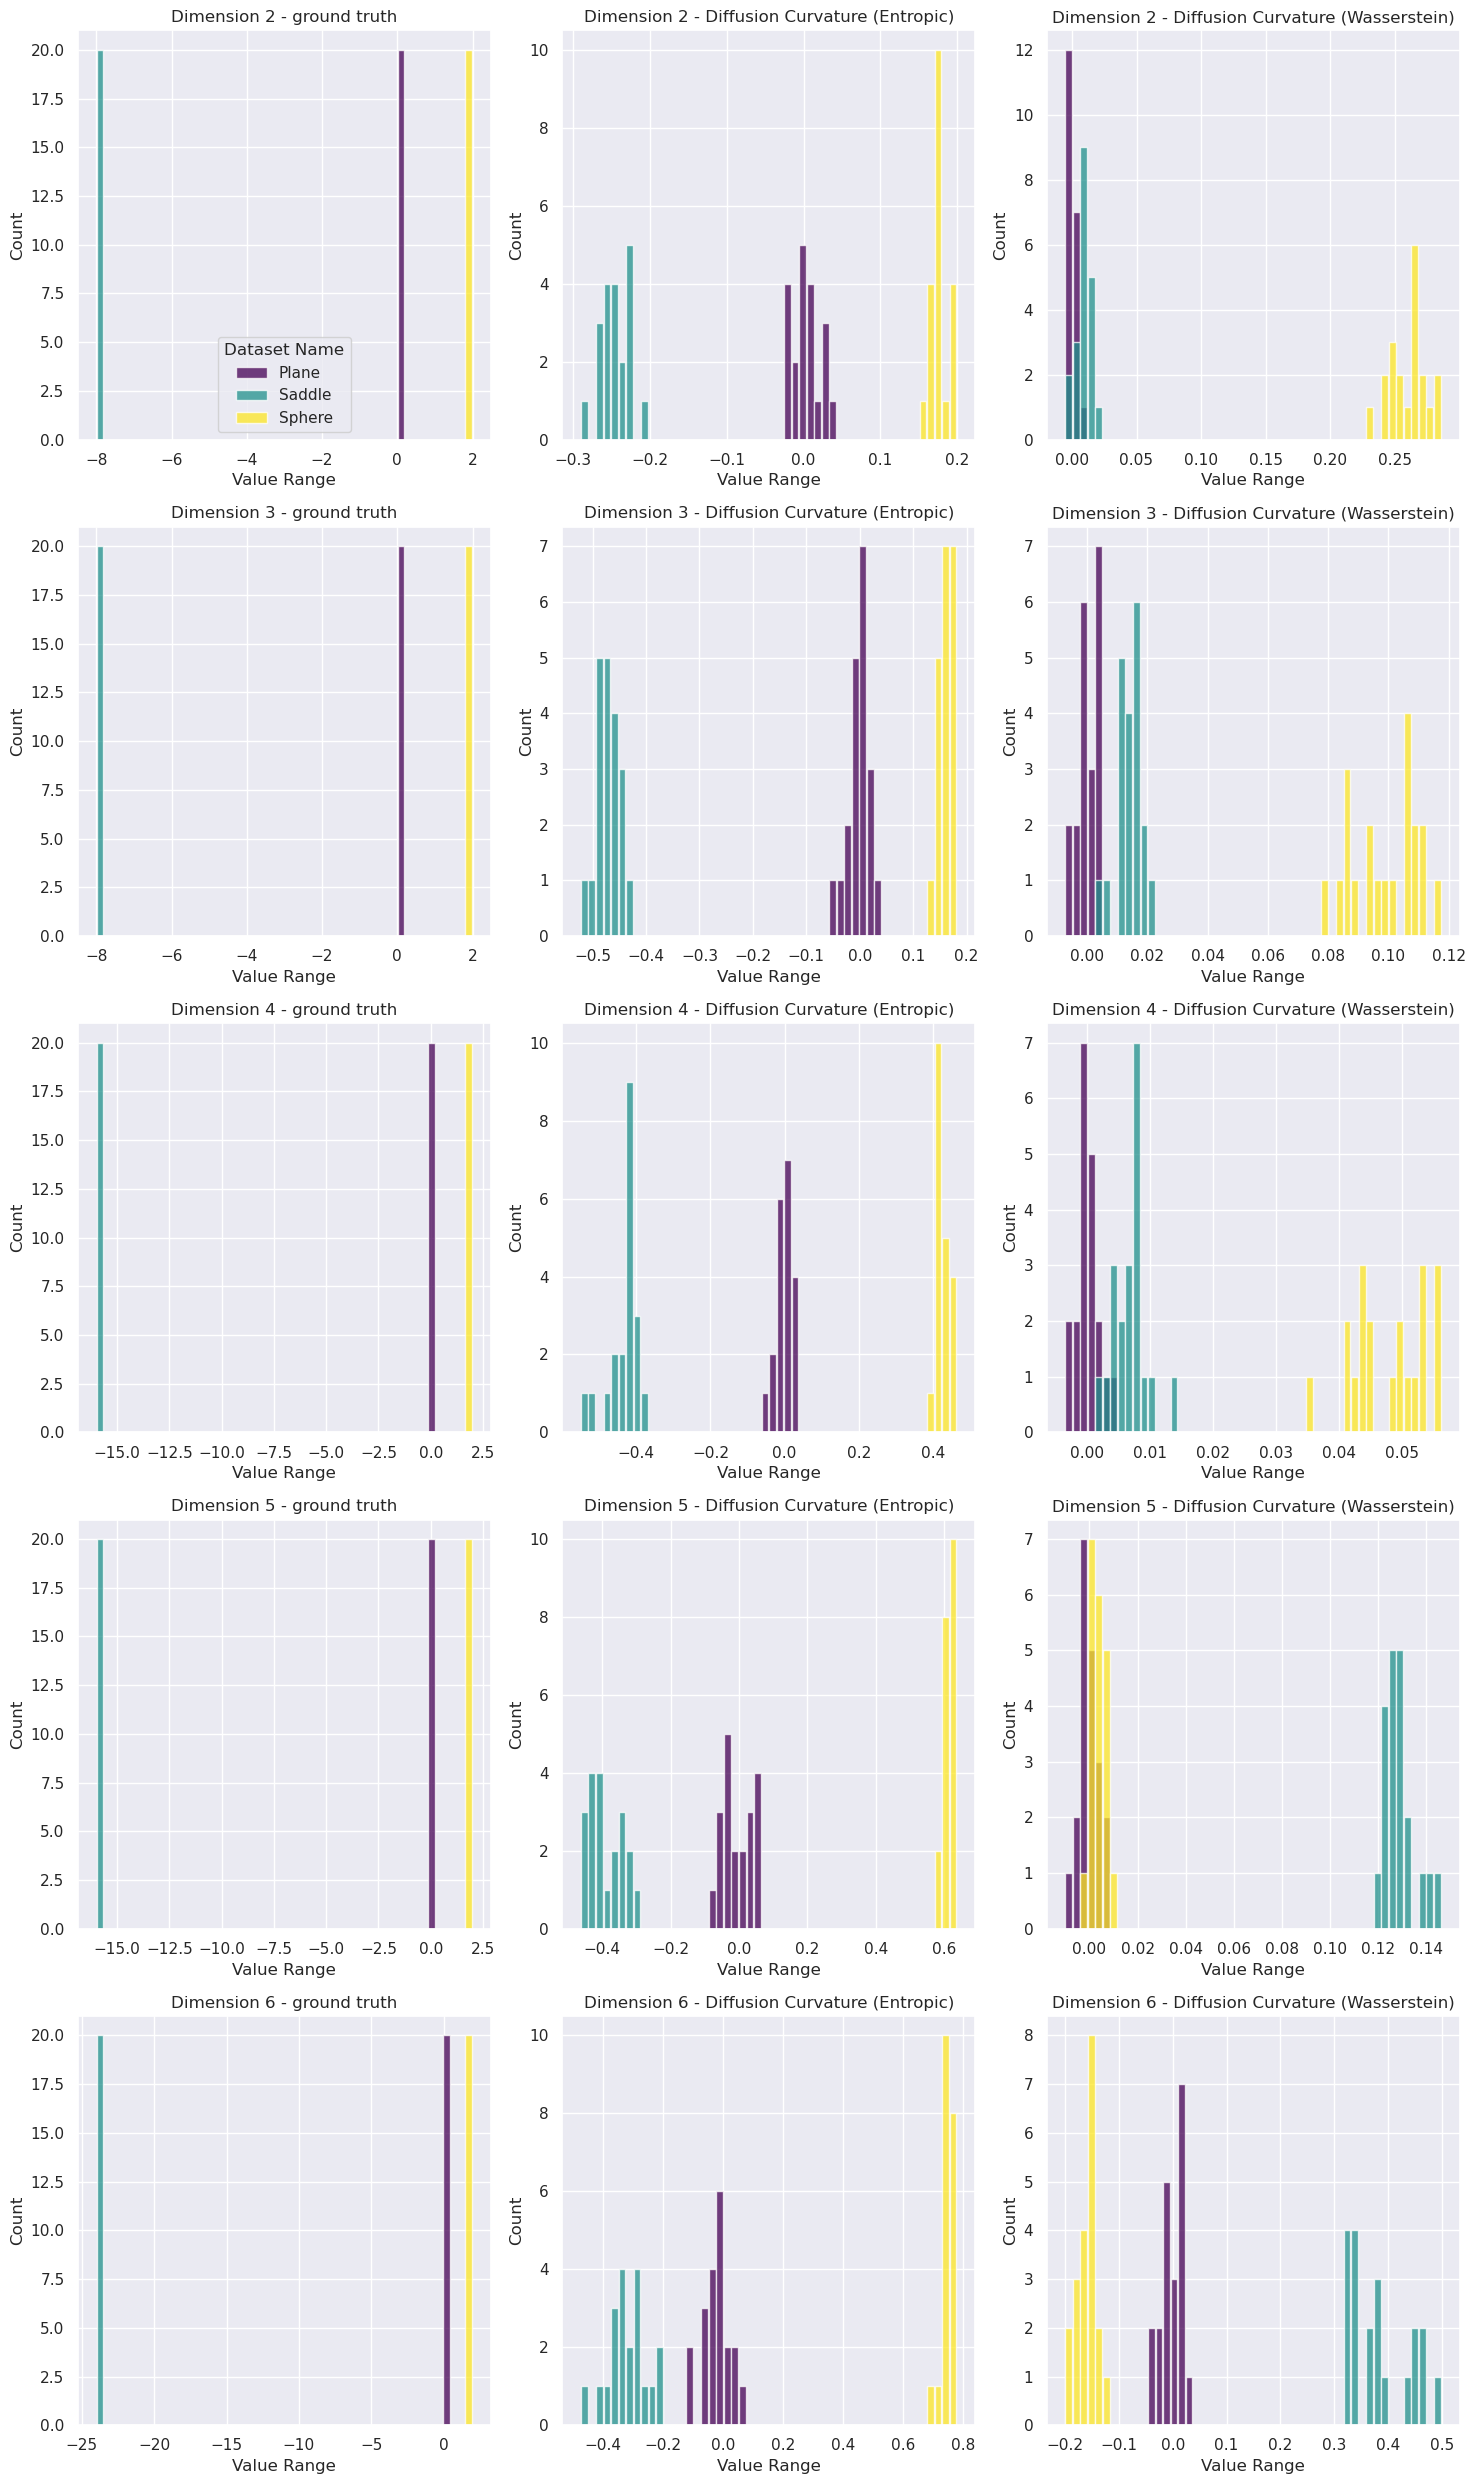

In [7]:
#| label: fig-sadspheres
#| fig-cap: Predicted curvatures of Saddles and Spheres in dimensions 2-6. Diffusion Curvature robustly distinguishes between the signs of the data, even in high dimensions, and with relative sparsity.
#| fig-alt: ...
SS1._aggregate_labels()
SS1.plot_by_dimension()

# Conclusion